### imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import sklearn
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
import scipy
from scipy.stats import pearsonr, f_oneway, norm

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

### read the data

In [3]:
sales = pd.read_csv('train.csv').set_index('date')
oil = pd.read_csv('oil.csv')
stores = pd.read_csv('stores.csv')
holidays = pd.read_csv('holidays_events.csv')

In [4]:
# renaming oil price column
oil.rename({'dcoilwtico':'oil_price'},axis=1,inplace=True)

# change dates to a datetime type
sales.index = pd.to_datetime(sales.index)
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

In [5]:
print('number of stores in the data:', sales['store_nbr'].unique().shape[0])
print('start date: ', sales.index.min())
print('end date: ', sales.index.max())
print('period:', ( sales.index.max() - sales.index.min() ).days, 'days')

number of stores in the data: 54
start date:  2013-01-01 00:00:00
end date:  2017-08-15 00:00:00
period: 1687 days


In [6]:
sales.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


-------------------------------------------------------------------------------
get top 5 selling stores

In [7]:
sales.groupby('store_nbr').sum()['sales'].sort_values(ascending=False).head()

store_nbr
44    6.208755e+07
45    5.449801e+07
47    5.094831e+07
3     5.048191e+07
49    4.342010e+07
Name: sales, dtype: float64

to proceed with the forecasting, we'll select sales of store 44 (since it has the most orders). we will also sum all the categories because we want to predict total sales per day in store 44

In [8]:
sales = sales[sales['store_nbr']==44].groupby('date').sum()[['sales','onpromotion']].drop('2013-01-01').reset_index()
sales.head()

,date,sales,onpromotion
0,2013-01-02,30095.181,0
1,2013-01-03,20447.057,0
2,2013-01-04,22795.799,0
3,2013-01-05,31382.508,0
4,2013-01-06,36069.345,0


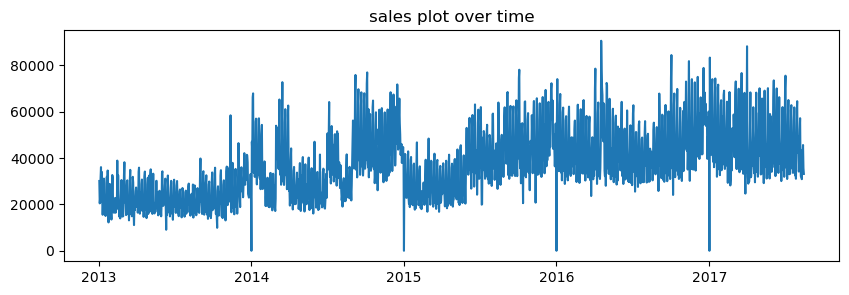

In [9]:
plt.figure(figsize=(10,3))
plt.plot(sales['date'],sales['sales'])
plt.title('sales plot over time')
plt.show()

-------------------
the store closes on the first of every year

In [10]:
sales[sales['sales']==0]

,date,sales,onpromotion
363,2014-01-01,0.0,0
727,2015-01-01,0.0,0
1091,2016-01-01,0.0,0
1456,2017-01-01,0.0,0


-------------------
saturday & sunday have highest sales, followed by monday

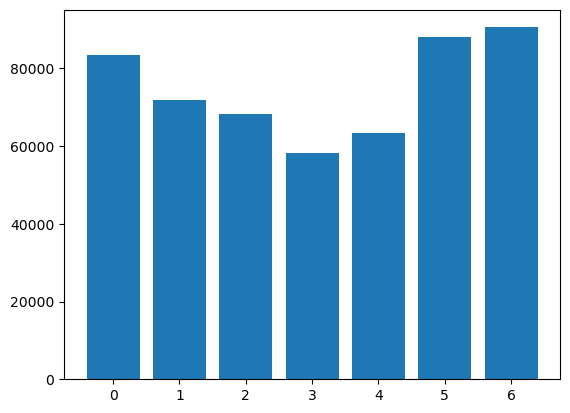

In [11]:
sales['dayofweek'] = sales['date'].dt.dayofweek
plt.bar(sales['dayofweek'],sales['sales'])
plt.show()


oil price plot over time. there are some missing values which we need to fill

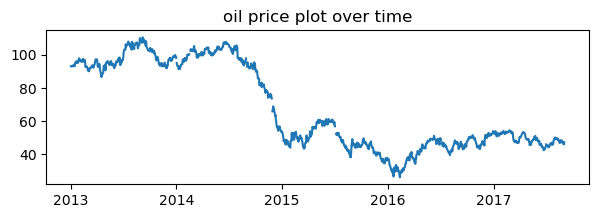

In [12]:
plt.figure(figsize=(7,2))
plt.plot(oil['date'],oil['oil_price'])
plt.title('oil price plot over time')
plt.show()

merging sales data with oil price data and then filling the missing oil price values

In [13]:
data = pd.merge(left=sales,right=oil,on='date',how='left')
data['oil_price'] = data['oil_price'].fillna(method='ffill')

holidays table

In [14]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


now we need to take care of the holidays table by one-hot encoding the categorical features

In [15]:
holidays_one_hot = pd.concat([
    holidays['date'],
    pd.get_dummies(holidays[['type','locale','locale_name','transferred']])    
], axis=1)

holidays_one_hot = holidays_one_hot.groupby('date').mean().reset_index()

holidays_one_hot.head()

,date,transferred,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,locale_Local,locale_National,...,locale_name_Machala,locale_name_Manta,locale_name_Puyo,locale_name_Quevedo,locale_name_Quito,locale_name_Riobamba,locale_name_Salinas,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas
0,2012-03-02,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-04-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-04-12,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-04-14,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-04-21,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [16]:
# merge the current data with the holidays data
data = pd.merge(left=data,right=holidays_one_hot,on='date',how='left')

def map_func(x):
    if x<0.5: 
        return 'not transferred' 
    elif x>=0.5:
        return 'is transferred'
    else:
        return 'N/A transferred'

# converting the transfered column from numerical to categorical
temp = pd.get_dummies(
    data['transferred'].map(map_func)
)

# concat the data
data = pd.concat([data,temp],axis=1)

# drop the original transferred column
data = data.drop('transferred',axis=1)

# fill null values with zero
data.fillna(0,inplace=True)
data.head()

,date,sales,onpromotion,dayofweek,oil_price,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,...,locale_name_Quevedo,locale_name_Quito,locale_name_Riobamba,locale_name_Salinas,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas,N/A transferred,is transferred,not transferred
0,2013-01-02,30095.181,0,2,93.14,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,2013-01-03,20447.057,0,3,92.97,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2,2013-01-04,22795.799,0,4,93.12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
3,2013-01-05,31382.508,0,5,93.12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
4,2013-01-06,36069.345,0,6,93.12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0


In [17]:
# one-hot encode the day of week and then drop the original variable 
data = pd.concat([
    data,
    pd.get_dummies(data['dayofweek'], 'dow')],
    axis=1
).drop('dayofweek',axis=1)

In [18]:
# correlation of different variables with sales
data.corr()[['sales']]

,sales
sales,1.000000
onpromotion,0.440395
oil_price,-0.477437
type_Additional,0.079034
type_Bridge,0.019023
type_Event,0.080373
type_Holiday,0.007296
type_Transfer,0.054969
type_Work Day,0.013604
locale_Local,0.002297


### Testing The Effect of Holiday on sales using multiple methods

### 9% correlation with very small p-value
this means that the holiday variable is important in predicting sales

In [19]:
is_holiday = (data['N/A transferred']!=1).astype(int)
pearsonr(is_holiday,data['sales'])

(0.08941491761783751, 0.00023988368322658108)

In [20]:
# get the sales data for holidays and regular days separately 
holiday = data[data['N/A transferred']!=1]['sales'].values
regular = data[data['N/A transferred']==1]['sales'].values

In [21]:
holiday.shape

(251,)

### hypothesis testing using repeated sampling
we will sample 251 days of regular day sales then get the mean. we will repeat this sampling 10,000 times and see how many times this mean will be above the holiday mean

In [22]:
means = np.array([])
for i in range(100000):
    means = np.append(
        means,
        np.random.choice(regular,251).mean()
    )

In [23]:
# in 99,999 times out of 100,000 the non-holiday mean is less than the holidays sample mean
# => p-value 1/100,000 = 1e^-05

In [24]:
(means<holiday.mean()).sum()

99999

In [25]:
# based on the 10,000 repeated samples, here is the standard deviation of sample means
means.std()

908.2497495566623

sample mean from regular days should have a standard deviation of std/sqrt(n)

In [26]:
std = regular.std()/np.sqrt(len(holiday))
std

911.4948657356672

### hypothesis testing using a z-test method

In [27]:
z_value = ( holiday.mean() - regular.mean() ) / std
print('z-value=',z_value)
print('p-value=',1-norm.cdf(z_value))

z-value= 4.041749337875318
p-value= 2.6526964066020398e-05


## Conclusion:
we find that all methods lead to the same conclusion which is that holidays has a significant effect on sales

------------------------

----------------------

### Dickey Fuller Stationarity Test

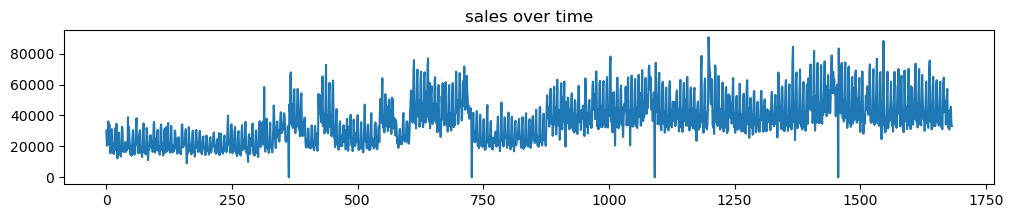

In [28]:
plt.figure(figsize=(12,2))
plt.plot(data['sales'])
plt.title('sales over time')
plt.show()

In [29]:
result = adfuller(data['sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print('stationary')
else:
    print('not stationary')

print('-------------------')

result = adfuller(data['oil_price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print('stationary')
else:
    print('not stationary')

ADF Statistic: -2.944131
p-value: 0.040452
stationary
-------------------
ADF Statistic: -0.875857
p-value: 0.795819
not stationary


based on the above results, we find that sales data is stationary, but oil prices are not

-----------------

### auto correlation plot
there is a clear weekly seasonality

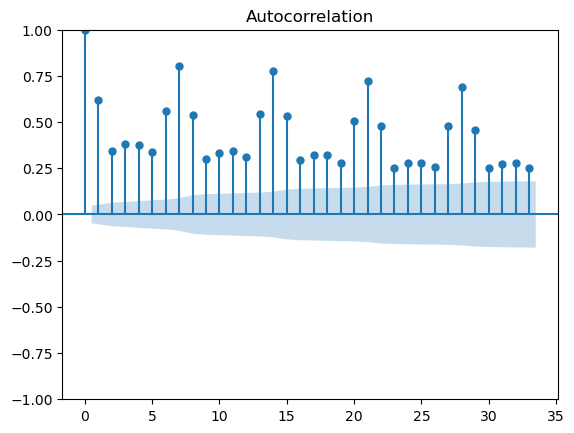

In [30]:
plot_acf(data['sales'])

C:\Users\ahmed.al.2\Anaconda3\envs\AhmedEnv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


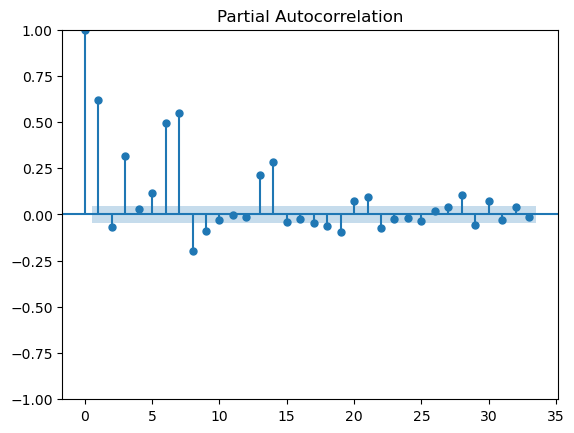

In [31]:
plot_pacf(data['sales'])

### through experimentation, this is the best result

In [32]:
# ARIMAX model
model = ARIMA(data['sales'],
              exog=data[['onpromotion', 'oil_price','type_Additional', 'type_Bridge', 'type_Event', 'type_Holiday',
       'type_Transfer','type_Work Day', 'locale_Local', 'locale_National','locale_Regional',
                         'dow_0', 'dow_1', 'dow_2',
       'dow_3', 'dow_4', 'dow_5', 'dow_6']],
              order=(7,0,10),
            )

# fit model
model_fit = model.fit()

# predict on the last 100 days
pred = model_fit.predict()[-100:]

# MAE
print(abs(pred-data['sales'].iloc[-100:]).mean())

C:\Users\ahmed.al.2\Anaconda3\envs\AhmedEnv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3753.7711806357925


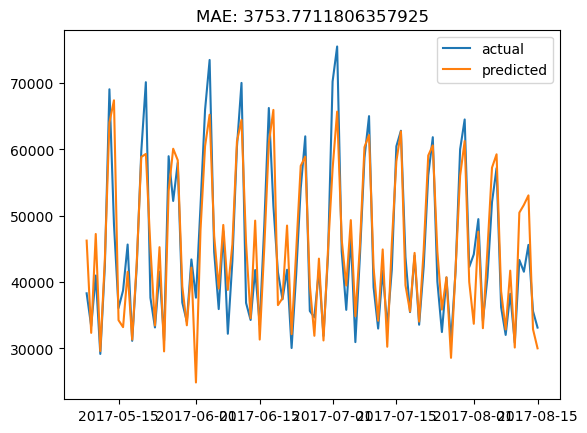

In [34]:
# get number of test days
test_days = len(pred)

# plot actual sales
plt.plot(
    data['date'].iloc[-test_days:]
    ,data['sales'].iloc[-100:]
)

# plot predicted sales
plt.plot(
    data['date'].iloc[-test_days:],
    pred
)

# title and legend
plt.title(
    f"MAE: {abs(pred-data['sales'].iloc[-100:]).mean()}"
)

plt.legend(['actual','predicted'])
plt.show()